In [57]:
os.chdir("/home/galaxy/project/alleleSpecific_analysis/data/shFUS/bam_wasp/bam/forKD1/peak_1/")
df = pd.read_table("NC_vs_T.count")

# ### bam stat
count_file = "/home/galaxy/project/alleleSpecific_analysis/data/shFUS/bam_wasp/bam/bam.count"
df_c = pd.read_table(count_file, header=None)
count_dict = dict(zip(df_c.iloc[:,0], df_c.iloc[:,1]))
print(count_dict)
###
sample_cols = df.columns[5:].tolist()
df['peak_len'] = df['end'] - df['start']
for sample in sample_cols:
    df['%s_rpkm'%sample] = (df[sample] * 1000000000) / (df['peak_len'] * count_dict[sample])
df['peak'] = df['#chro'] + ":" + df['start'].astype(str) + "-" + df['end'].astype(str)
sample_list = list(set([x.split("_")[0] for x in sample_cols]))
for case in sample_list:
    df['%s_m6ALevel'%case] = (df['%s_m6A_rpkm'%case]+1) / (df['%s_input_rpkm'%case]+1)
### txt format
df_final = df[['peak'] + ["%s_m6ALevel" % x for x in sample_list]]
print(df_final.head())
df_final.to_csv("FPKM_matrix.txt", sep="\t", index=False)
### bed format
df_final = df[['#chro', 'start', 'end'] + ["%s_m6ALevel" % x for x in sample_list]]
df_final.to_csv("FPKM_matrix.bed", sep="\t", index=False)

{'kd2_input': 59254724, 'kd_input': 68023740, 'wt_input': 78164647, 'wt2_input': 46888237, 'kd2_m6A': 117018661, 'kd_m6A': 84298167, 'wt_m6A': 85184165, 'wt2_m6A': 90201519}
                 peak  kd_m6ALevel  wt_m6ALevel
0    chr1:14430-14836     4.081322     5.968109
1    chr1:14445-14824     4.162423     6.085593
2  chr1:777604-777808     3.295850     3.539686
3  chr1:777605-777838     3.162052     3.396524
4  chr1:778435-779014     2.334561     2.037605


In [77]:
os.chdir("/home/galaxy/project/alleleSpecific_analysis/data/shFUS/bam_wasp/bam/forKD1/peak_1/")
os.system("mkdir -p targets")
os.system("mkdir -p non-targets")
###### pick out m6A peak
# in_file = "FPKM_matrix.bed"
# m6a_peak = "/home/galaxy/project/alleleSpecific_analysis/data/shFUS/peak/merged_peak_MSPC/wt/ConsensusPeaks.bed"
###
m6a_bed = "FPKM_matrix.bed"
# os.system("bedtools intersect -a %s -b %s -wa | sort -u > %s" % (in_file, m6a_peak, m6a_bed))
### 手工加header [#chro   start   end     NC_m6ALevel     T1_m6ALevel     T2_m6ALevel     T3_m6ALevel]
### split into targets and non-targets
### process biological repeats
df = pd.read_table(m6a_bed) # , header=None
# df.columns = ['#chro','start', 'end', 'wt_m6ALevel','wt2_m6ALevel','kd_m6ALevel','kd2_m6ALevel']
# kd_samples = df.columns[5:].tolist()
#####
def split_group(sample_name):
#     fus = "/home/galaxy/data/RBP/POSTAR/POSTAR_bed/FUS_HEK293T_hg19.bed"
#     fus = "/home/galaxy/data/RBP/POSTAR/POSTAR_bed/FUS_brain_hg19.bed"
    fus = "/home/galaxy/project/alleleSpecific_analysis/data/RBP/ENCODE/eCLIP/FUS/combine/union_hg19.bed"
#     fus = "/Charles/project/ASm6A/data/RBP/union/union.bed"
#     fus = "/Charles/project/ASm6A/data/RBP/union/ContainingFUS_genes.bed"
#     fus = "/home/galaxy/data/RBP/POSTAR/POSTAR_bed/FUS_HEK293T_hg19.bed"
#     fus = "/home/galaxy/data/RBP/POSTAR/POSTAR_bed/FUS_brain_hg19.bed"
    #### combine all FUS sets + Gene + Promoter
    fus_target_genes  = "/Charles/project/ASm6A/data/RBP/union/ContainingFUS_genes_promoter.bed"
#     fus_target_genes = "/home/galaxy/data/RBP/POSTAR/POSTAR_bed/tmp/FUS_brain_GenePromoter_hg19.bed"
#     fus_target_genes = "/home/galaxy/data/RBP/POSTAR/POSTAR_bed/tmp/FUS_brain_Gene_hg19.bed"
#     fus_target_genes = "/home/galaxy/data/RBP/POSTAR/POSTAR_bed/FUS_brain_hg19.bed"
    ####
    df_sub = df[['#chro', 'start', 'end', "wt_m6ALevel", sample_name]] ##
    bed = "%s.bed"%sample_name
    df_sub.to_csv(bed, sep="\t", index=False)
    res = "targets/%s" % os.path.basename(bed)
    os.system("bedtools intersect -a %s -b %s -wa | sort -u > %s" % (bed, fus, res))
    res = "non-targets/%s" % os.path.basename(bed)
    os.system("bedtools intersect -a %s -b %s -v -wa | sort -u > %s" % (bed, fus_target_genes, res))
    os.remove(bed)
    
# for kd in kd_samples:
#     print(kd)
split_group("kd_m6ALevel")

Target 86 86
None-targets 86 86


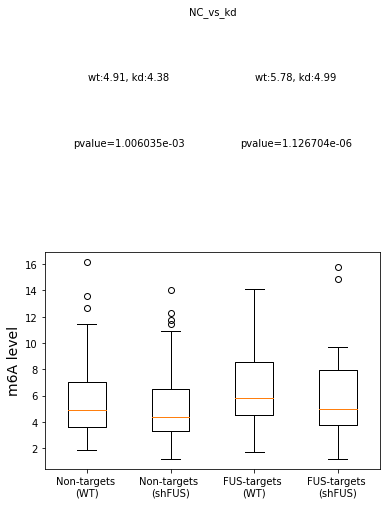

In [78]:
# boxplot 
#### another form of plot
import random
from scipy import stats
import matplotlib.pyplot as plt

target_dir = "/home/galaxy/project/alleleSpecific_analysis/data/shFUS/bam_wasp/bam/forKD1/peak_1/targets/"
non_dir = "/home/galaxy/project/alleleSpecific_analysis/data/shFUS/bam_wasp/bam/forKD1/peak_1/non-targets/"

def get_fc_list(in_file):
    df = pd.read_table(in_file, header=None)
    df = df.dropna()
    wt_list = df.iloc[:,3].tolist()
    wt_list = [x for x in wt_list if x != "nan"]
    kd_list = df.iloc[:,4].tolist()
    kd_list = [x for x in kd_list if x != "nan"]
#     fc_list = [np.log2(x+1) for x in fc_list]
    return wt_list, kd_list
    
# for target_file in target_list:
#     non_file = os.path.join(non_dir, os.path.basename(target_file))
#     #
#     n_wt_list, n_kd_list = get_fc_list(non_file)
#     stat, pvalue = stats.mannwhitneyu(n_wt_list, n_kd_list)
#     a1,b1,c1,d1 = round(np.mean(n_wt_list),2), round(np.mean(n_kd_list),2), round(stat,2), round(pvalue,4)
#     #
#     t_wt_list, t_kd_list = get_fc_list(target_file)
#     stat, pvalue = stats.mannwhitneyu(t_wt_list, t_kd_list)
#     a2,b2,c2,d2 = round(np.mean(t_wt_list),2), round(np.mean(t_kd_list),2), round(stat,2), round(pvalue,4)
#     print(os.path.basename(target_file), a1,b1,d1, a2,b2,d2)
sample = "kd_m6ALevel.bed"
target_file = os.path.join(target_dir, sample)
non_file = os.path.join(non_dir, sample)
##
t_wt_list, t_kd_list = get_fc_list(target_file)
t_median = "wt:%s, kd:%s" % (str(round(np.median(t_wt_list),2)), str(round(np.median(t_kd_list),2)))
t_stat, t_pvalue = stats.ttest_rel(t_wt_list, t_kd_list)
print("Target", len(t_wt_list), len(t_kd_list))
##
n_wt_list, n_kd_list = get_fc_list(non_file)
random_index_list = random.sample(list(range(len(n_wt_list))), len(t_wt_list))
n_wt_list, n_kd_list = [n_wt_list[i] for i in random_index_list], [n_kd_list[i] for i in random_index_list]
n_median = "wt:%s, kd:%s" % (str(round(np.median(n_wt_list),2)), str(round(np.median(n_kd_list),2)))
n_stat, n_pvalue = stats.ttest_rel(n_wt_list, n_kd_list)
print("None-targets", len(n_wt_list), len(n_kd_list))
####
x = [n_wt_list,n_kd_list,t_wt_list,t_kd_list]
plt.boxplot(x, labels=["Non-targets \n(WT)","Non-targets \n(shFUS)","FUS-targets \n(WT)","FUS-targets \n(shFUS)"])
plt.ylabel('m6A level', size = 14)
plt.xticks(rotation=0)
plt.text(1.5, 25, 'pvalue=%e'%n_pvalue, horizontalalignment='center')
plt.text(1.5, 30, n_median, horizontalalignment='center')
plt.text(3.5, 25, 'pvalue=%e'%t_pvalue, horizontalalignment='center')
plt.text(3.5, 30, t_median, horizontalalignment='center')
plt.text(2.5, 35, "NC_vs_%s"%sample.split("_")[0], horizontalalignment='center')
plt.show()

kd_m6ALevel.bed -0.21110691519718056 -0.1787121339102731 86 1285 0.039046657827843445


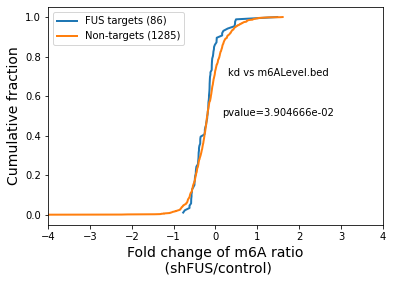

In [79]:
#### compare (kd-test)
import random
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dc_stat_think as dcst

target_dir = "/home/galaxy/project/alleleSpecific_analysis/data/shFUS/bam_wasp/bam/forKD1/peak_1/targets/"
non_dir = "/home/galaxy/project/alleleSpecific_analysis/data/shFUS/bam_wasp/bam/forKD1/peak_1/non-targets/"
target_list = glob.glob("%s/*.bed" % target_dir)

def get_fc_list(in_file):
    df = pd.read_table(in_file, header=None)
    df = df.dropna()
    df['fc'] = df.iloc[:,4] / df.iloc[:,3]
    fc_list = df['fc'].tolist()
    fc_list = [x for x in fc_list if x != "nan"]
    fc_list = [np.log2(x) for x in fc_list]
    return fc_list
    
# for target_file in target_list:
#     non_file = os.path.join(non_dir, os.path.basename(target_file))
#     t_list, n_list = get_fc_list(target_file), get_fc_list(non_file)
# #     n_list = random.sample(n_list, len(t_list))
#     (ks_stat, pval) = stats.ks_2samp(t_list, n_list)
#     if np.mean(t_list) > np.mean(n_list):
#         print(os.path.basename(target_file), np.mean(t_list), np.mean(n_list), ks_stat, pval)

target_file = os.path.join(target_dir, "kd_m6ALevel.bed")
non_file = os.path.join(non_dir, "kd_m6ALevel.bed")
t_list, n_list = get_fc_list(target_file), get_fc_list(non_file)
####
# n_list = random.sample(n_list, len(t_list))
(ks_stat, pval) = stats.ks_2samp(t_list, n_list)
print(os.path.basename(target_file), np.mean(t_list), np.mean(n_list), len(t_list), len(n_list), pval)

x_asm6a, y_asm6a = dcst.ecdf(t_list)
x, y = dcst.ecdf(n_list)
_ = plt.plot(x_asm6a, y_asm6a, lw = 2)
_ = plt.plot(x, y, lw = 2) # linestyle='--', 
_ = plt.legend(("FUS targets (%d)"% len(t_list), "Non-targets (%d)" % len(n_list)))
_ = plt.xlabel('Fold change of m6A ratio\n (shFUS/control)', size = 14) # Log2 
_ = plt.ylabel('Cumulative fraction', size = 14)
_ = plt.text(1.5, 0.5, 'pvalue=%e'%pval, horizontalalignment='center')
sample = os.path.basename(target_file).split("_m6A.txt")[0].replace("_", " vs ")
_ = plt.text(1.5, 0.7, sample, horizontalalignment='center')
_ = plt.xlim((-4,4))
plt.show()

1508 1285


/home/galaxy/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


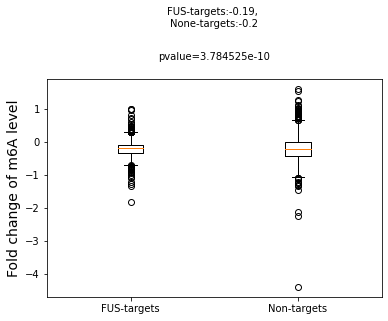

In [71]:
t_list, n_list = get_fc_list(target_file), get_fc_list(non_file)
print(len(t_list), len(n_list))
##
(ks_stat, pval) = stats.ks_2samp(t_list, n_list)
###
x = [t_list, n_list]
x_median = "FUS-targets:%s, \nNone-targets:%s" % (str(round(np.median(t_list),2)), str(round(np.median(n_list),2)))
plt.boxplot(x, labels=["FUS-targets","Non-targets"])
plt.ylabel('Fold change of m6A level', size = 14)
plt.xticks(rotation=0)
plt.text(1.5, 2.5, 'pvalue=%e'%pval, horizontalalignment='center')
plt.text(1.5, 3.5, x_median, horizontalalignment='center')
plt.show()